In [205]:
import pandas as pd
import numpy as np
import warnings 
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from scipy.ndimage import median_filter
import os
import shutil
import random
import splitfolders
from shutil import copyfile
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Activation, Add
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import kerastuner as kt
from tensorflow.keras.optimizers import Adam, RMSprop
from kerastuner import Hyperband

In [206]:
warnings.filterwarnings('ignore')

In [207]:
def remove_all_files_and_directories(directory):
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"The directory '{directory}' does not exist.")
        return

    # Remove all files in the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

    # Remove all subdirectories in the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)

    # Remove the top-level directory itself
    os.rmdir(directory)

# 1. Chargement et prétraitement des images

## 1.1 Prétraitement d'image

In [208]:
# Function de prétraitement d'images
def pretraitement_image(img):    
    # 1) Whitening (blanchiment) : Normalisation des valeurs de pixels avec centarge et la mise en echelle
    img = (img - np.mean(img)) / np.std(img)

    # 2) auto Contraste: ajuster automatiquement le contraste d'une image pour étendre 
    # la gamme de valeurs de pixel sur toute l'échelle des couleurs. (hist plus large)

    # Calculer les valeurs minimales et maximales des pixels de l'image
    min_value = tf.reduce_min(img)
    max_value = tf.reduce_max(img)
    # Appliquer la transformation linéaire pour ajuster automatiquement le contraste
    img = (img - min_value) * (255.0 / (max_value - min_value))
    # Convertir les valeurs des pixels en type uint8 (entiers non signés sur 8 bits)
    img = tf.cast(img, tf.uint8)
    
    # 3) Equalization :améliorer la répartition des intensités de pixels dans une image (hist plus plat)
#    img = exposure.equalize_hist(img)
    img = tfa.image.equalize(img)

    # 4) Débruitage (ajouter du bruit gaussien et supprimer le bruit par filtrage)
    img = img + 0.1 * np.random.randn(*img.shape)
    img = median_filter(img, size=(3, 3, 3))

    return img

Un example de pretraitement d'image

In [209]:
# Charger une image (vous pouvez remplacer cette étape par le chargement de votre propre image)
image_path = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/Images/n02085620-Chihuahua/n02085620_242.jpg"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)

# Cropping
cropped_image = image[50:150, 50:150]

# Whitening (blanchiment)
whitened_image = (image - np.mean(image)) / np.std(image)

# Contraste
# Calculer les valeurs minimales et maximales des pixels de l'image
min_value = tf.reduce_min(image)
max_value = tf.reduce_max(image)

# Appliquer la transformation linéaire pour ajuster automatiquement le contraste
autocontrasted_image = (image - min_value) * (255.0 / (max_value - min_value))

# Convertir les valeurs des pixels en type uint8 (entiers non signés sur 8 bits)
autocontrasted_image = tf.cast(autocontrasted_image, tf.uint8)

# Égalisation : améliorer la répartition des intensités de pixels dans une image

#equalized_image = tfa.image.equalize(image)
#equalized_image = tf.image.experimental.equalize(image)
def equalize_histogram(img):
    img_shape = img.shape
    img_flat = img.flatten()
    hist, bins = np.histogram(img_flat, bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    img_equalized_flat = np.interp(img_flat, bins[:-1], cdf_normalized)
    img_equalized = img_equalized_flat.reshape(img_shape)
    return img_equalized

equalized_image = equalize_histogram(image)

# Débruitage (ajouter du bruit gaussien et supprimer le bruit par filtrage)
noisy_image = image + 0.1 * np.random.randn(*image.shape)
denoised_image = median_filter(noisy_image, size=(3, 3, 3))

# Redimensionnement
processed_image = pretraitement_image(image)


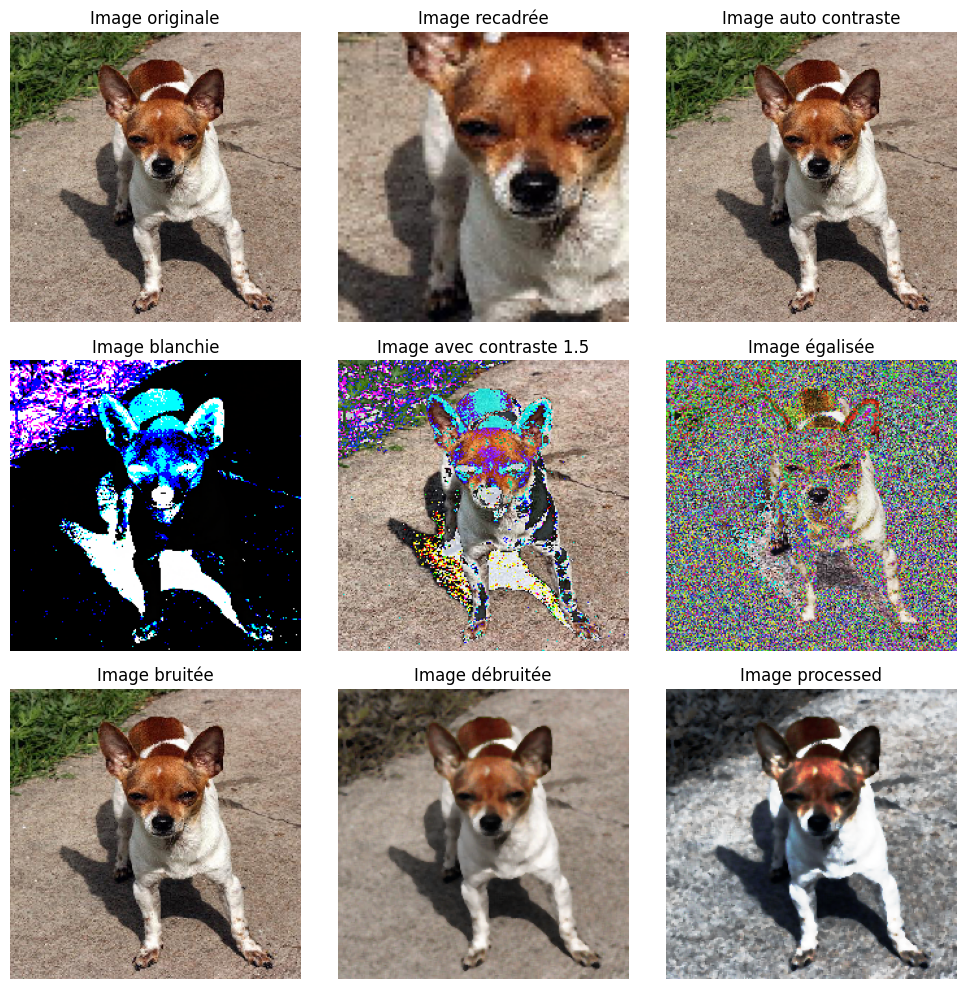

In [210]:
# Créer une figure avec 3x3 sous-tracés
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Afficher les images sur les sous-tracés
axes[0, 0].imshow(image.astype(np.uint8))
axes[0, 0].set_title("Image originale")

axes[0, 1].imshow(cropped_image.astype(np.uint8))
axes[0, 1].set_title("Image recadrée")

axes[0, 2].imshow(autocontrasted_image.numpy().astype(np.uint8))
axes[0, 2].set_title("Image auto contraste")

axes[1, 0].imshow(whitened_image.astype(np.uint8))
axes[1, 0].set_title("Image blanchie")

axes[1, 1].imshow(contrasted_image.numpy().astype(np.uint8))
axes[1, 1].set_title("Image avec contraste 1.5")

#axes[1, 2].imshow(tf.image.convert_image_dtype(equalized_image, tf.uint8))
axes[1, 2].imshow(equalized_image.astype(np.uint8))
axes[1, 2].set_title("Image égalisée")

axes[2, 0].imshow(noisy_image.astype(np.uint8))
axes[2, 0].set_title("Image bruitée")

axes[2, 1].imshow(denoised_image.astype(np.uint8))
axes[2, 1].set_title("Image débruitée")

axes[2, 2].imshow(processed_image.astype(np.uint8))
axes[2, 2].set_title("Image processed")

# Afficher les titres des sous-tracés
for ax in axes.flat:
    ax.axis("off")

# Ajuster les espacements entre les sous-tracés
plt.tight_layout()

# Afficher la figure
plt.show()

## 1.2 Augmentation d'image pour les entrainements

In [211]:
# Définir les transformations de data augmentation
train_data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Angle de rotation aléatoire
    width_shift_range=0.2,  # Décalage horizontal aléatoire
    height_shift_range=0.2,  # Décalage vertical aléatoire
    shear_range=0.2,  # Déformation de cisaillement aléatoire
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Retournement horizontal aléatoire
    vertical_flip=False,  # Retournement vertical aléatoire
    preprocessing_function=pretraitement_image  # Prétraitement spécifique 
)

In [212]:
# Créer un générateur de données pour le sous-ensemble de validation
validation_data_gen = ImageDataGenerator(
    preprocessing_function=pretraitement_image
)

## 1.3 Chargement et préparation des images test et train

In [213]:
# Chemin vers le dossier contenant les images du dataset
data_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/Images"

In [214]:
# Définir le rapport de division entre l'entraînement et la validation
# Ici, on utilise 80% pour l'entraînement et 20% pour la validation
ratio = (0.8, 0.2)

output_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/output"
remove_all_files_and_directories(output_dir)

# Diviser les images en sous-ensembles d'entraînement et de validation
splitfolders.ratio(data_dir, output=output_dir, seed=123, ratio=ratio, group_prefix=None)

# Chemin vers le dossier contenant les images d'entraînement
train_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/output/train"

# Chemin vers le dossier contenant les images de validation
validation_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/output/val"

Copying files: 20580 files [00:48, 421.31 files/s]


In [215]:
# Chargement des images avec leurs classes
batch_size = 32
img_height, img_width = 224, 224  # Vous pouvez ajuster la taille des images selon vos besoins

# Charger les images pour l'entraînement
train_images = train_data_augmentation.flow_from_directory(
    train_dir,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Charger les images pour la validation
validation_images = validation_data_gen.flow_from_directory(
    validation_dir,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 16418 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [216]:
# Obtenir les classes de chiens à partir de l'objet train_images
class_indices = train_images.class_indices

# Inverser le dictionnaire pour obtenir les noms de classes associés aux identifiants de classe
class_names = list(class_indices.keys())

print("Classes de chiens :", class_names[:10])

Classes de chiens : ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']


## 1.4 Chargement et préparation d'un subset des images augmentés

# 1.4.1 Création du subset images

In [217]:
# Chemin vers le dossier contenant toutes les images du dataset
data_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/Images"

# Définir les classes que vous souhaitez charger
selected_classes = ['n02087046-toy_terrier', 'n02091134-whippet', 'n02098413-Lhasa']

# Définir le nombre d'images par classe que vous souhaitez charger
num_images_per_class = 100

# Chemin vers le dossier où vous souhaitez sauvegarder le sous-ensemble d'images
subset_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/Images"

# Call the function to remove all files and directories
remove_all_files_and_directories(subset_dir)

# Parcourir les sous-dossiers correspondant aux classes sélectionnées
for class_name in selected_classes:
    class_dir = os.path.join(data_dir, class_name)
    subset_class_dir = os.path.join(subset_dir, class_name)

    # Créer le dossier de sortie pour la classe si celui-ci n'existe pas déjà
    os.makedirs(subset_class_dir, exist_ok=True)

    # Charger la liste des fichiers d'images dans le sous-dossier de la classe
    image_files = os.listdir(class_dir)

    # Sélectionner un nombre aléatoire d'images pour la classe
    selected_images = random.sample(image_files, num_images_per_class)

    # Copier les images sélectionnées dans le dossier de sortie pour la classe
    for image_file in selected_images:
        src_path = os.path.join(class_dir, image_file)
        dst_path = os.path.join(subset_class_dir, image_file)
        copyfile(src_path, dst_path)

# 1.4.2 Chargement et préparation par data generator

In [218]:
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir la taille des images pour le modèle
img_height, img_width = 224, 224
batch_size = 32

# Chemin vers le dossier de sortie pour le sous-ensemble
subset_output_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output"

# Call the function to remove all files and directories
remove_all_files_and_directories(subset_output_dir)

# Utiliser splitfolders pour diviser les images en ensembles d'entraînement et de validation
splitfolders.ratio(subset_dir, output=subset_output_dir, seed=123, ratio=(0.8, 0.2), group_prefix=None)        

# Chemin vers le dossier contenant les images d'entraînement
subset_train_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/train"

# Chemin vers le dossier contenant les images de validation
subset_validation_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/val"

# Créer un générateur de données pour le sous-ensemble d'entraînement
train_data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=pretraitement_image
)

subset_train_images = train_data_gen.flow_from_directory(
    subset_train_dir,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Créer un générateur de données pour le sous-ensemble de validation
validation_data_gen = ImageDataGenerator(
    preprocessing_function=pretraitement_image
)

subset_validation_images = validation_data_gen.flow_from_directory(
    subset_validation_dir,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)


Copying files: 300 files [00:00, 862.87 files/s]

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [219]:
# Obtenir les classes de chiens à partir de l'objet train_images
class_indices = subset_train_images.class_indices

# Inverser le dictionnaire pour obtenir les noms de classes associés aux identifiants de classe
class_names = list(class_indices.keys())

print("Classes de chiens :", class_names)

Classes de chiens : ['n02087046-toy_terrier', 'n02091134-whippet', 'n02098413-Lhasa']


In [220]:
# Get the next batch from the data generator
batch = next(subset_train_images)

# Check the content and structure of the batch
print("Batch size:", len(batch))  # Size of the batch
#print("Batch data:", batch)       # Contents of the batch (e.g., images and labels)

Batch size: 2


In [221]:
# Chemin vers le dossier contenant les images de validation
subset_validation_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/val"

# Replace these paths with your actual directory paths
subset_test_dir = 'C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/test'

remove_all_files_and_directories(subset_test_dir)

# Create the test directory if it doesn't exist
if not os.path.exists(subset_test_dir):
    os.makedirs(subset_test_dir)
    subset_test_dir_img = os.path.join(subset_test_dir, 'img')
    os.makedirs(subset_test_dir_img)

# Traverse the subdirectories in the validation directory
for root, _, files in os.walk(subset_validation_dir):
    for image_file in files:
        src = os.path.join(root, image_file)
        dst = os.path.join(subset_test_dir_img, image_file)
        shutil.copyfile(src, dst)

print("Images copied from validation to test directory.")

The directory 'C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/test' does not exist.
Images copied from validation to test directory.


In [222]:
# Créer un générateur de données pour le sous-ensemble de test
test_data_gen = ImageDataGenerator(
    preprocessing_function=pretraitement_image
)

subset_test_images = test_data_gen.flow_from_directory(
    subset_test_dir,
    color_mode="rgb",
    class_mode=None,
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle=False,
    seed=42
)

Found 60 images belonging to 1 classes.


In [223]:
# Get the next batch from the data generator
batch = next(subset_test_images)

# Check the content and structure of the batch
print("Batch size:", len(batch))  # Size of the batch
#print("Batch data:", batch)       # Contents of the batch (e.g., images and labels)

Batch size: 1


# 2. CNN construction

## 2.1 Construction Modèle 

In [228]:
# Définir l'architecture du modèle CNN

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),    
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 128)      

In [226]:
# Définir le modèle CNN peu profond e 6 couches, sur l'architecture VGG
def build_model6(input_shape, num_classes):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),    
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

## 2.2. Entrainement  

Entrainement du modèle avec les sous ensembles images 
model.fit_generator est choisit pour utiliser les images préparées avec pretraitement et data augmentation. 

In [229]:
 hist=model.fit_generator(generator = subset_train_images,
                         epochs=20,
                         validation_data=subset_validation_images)
model_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/models"

model_path = os.path.join(model_dir, "model6.h5")
model.save(model_path)

Epoch 1/20
8/8 [==============================] - 34s 4s/step - loss: 140.3557 - accuracy: 0.3458 - val_loss: 15.1463 - val_accuracy: 0.3333
Epoch 2/20
8/8 [==============================] - 30s 3s/step - loss: 4.1760 - accuracy: 0.3542 - val_loss: 1.0737 - val_accuracy: 0.3667
Epoch 3/20
8/8 [==============================] - 30s 3s/step - loss: 1.0674 - accuracy: 0.4000 - val_loss: 1.0719 - val_accuracy: 0.3833
Epoch 4/20
8/8 [==============================] - 30s 3s/step - loss: 1.0410 - accuracy: 0.4292 - val_loss: 1.0458 - val_accuracy: 0.3833
Epoch 5/20
8/8 [==============================] - 29s 3s/step - loss: 1.0132 - accuracy: 0.4458 - val_loss: 1.1003 - val_accuracy: 0.4333
Epoch 6/20
8/8 [==============================] - 30s 4s/step - loss: 1.0310 - accuracy: 0.4625 - val_loss: 1.0639 - val_accuracy: 0.4500
Epoch 7/20
8/8 [==============================] - 31s 4s/step - loss: 1.0477 - accuracy: 0.4667 - val_loss: 1.1281 - val_accuracy: 0.4167
Epoch 8/20
8/8 [===============

In [230]:
def plot_model_history(model_history, start_epoch, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(start_epoch, start_epoch + len(model_history.history[acc]))
    
    axs[0].plot(epochs, model_history.history[acc])
    axs[0].plot(epochs, model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    
    axs[1].plot(epochs, model_history.history['loss'])
    axs[1].plot(epochs, model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

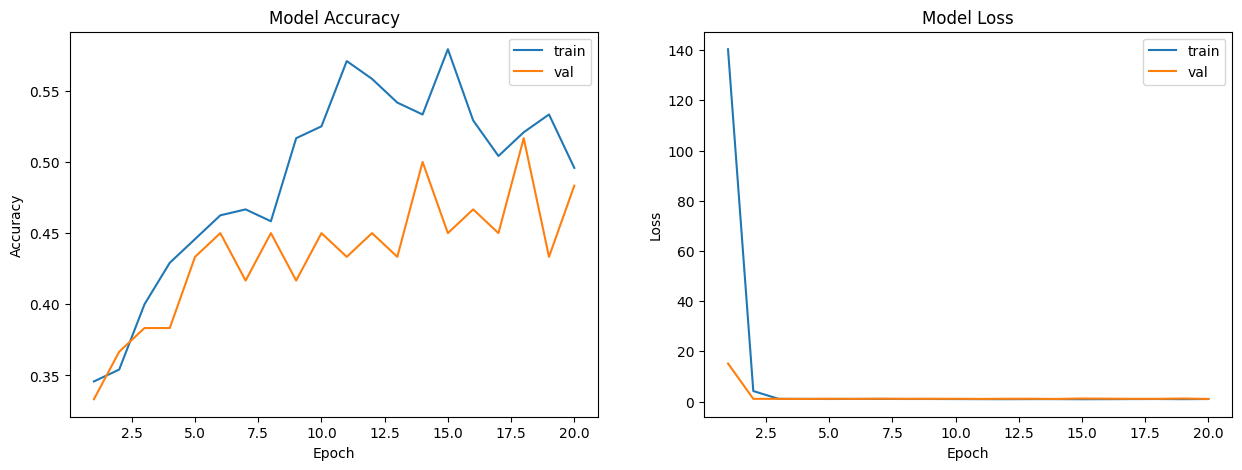

In [231]:
plot_model_history(hist, start_epoch=1)

## 2.3 Evaluation et prédiction

In [232]:
# Evaluation de performance 
loss, accuracy = model.evaluate_generator(subset_validation_images)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.483333  ;  loss = 1.049932 


In [233]:
STEP_SIZE_TEST=subset_test_images.n//subset_test_images.batch_size
subset_test_images.reset()

# prediction des classes dans le subset de validation
y_pred =  model.predict_generator(subset_test_images)

predicted_class_indices=np.argmax(y_pred,axis=1)

labels = (subset_train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#print(predictions)


In [234]:
filenames=subset_test_images.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [ ]:
confusion_mtx = confusion_matrix(y_g, y_p) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 2.4 Prédiction

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Charger le modèle entraîné
model = load_model('chemin_vers_modele.h5')  # Remplacez par le chemin de votre modèle sauvegardé

# Charger les images à prédire
image_paths = ['chemin_vers_image1.jpg', 'chemin_vers_image2.jpg']  # Liste des chemins vers les images à prédire

# Prétraitement des images
img_height, img_width = 224, 224  # Remplacez par la taille des images utilisée pour l'entraînement
images = []
for image_path in image_paths:
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    images.append(img_array)

# Concaténer les images en un seul tableau
images = np.vstack(images)

# Normaliser les valeurs des pixels entre 0 et 1 (si nécessaire)
images = images / 255.0

# Effectuer les prédictions
predictions = model.predict(images)

# Afficher les prédictions
print("Prédictions pour chaque image :")
for i, prediction in enumerate(predictions):
    print(f"Image {i+1} - Probabilités : {prediction}")


## 3. Hyperparamètres

## 3.1  Définir le modèle de base sans compilation

## 3.2.  fonction pour définir le tuner et spécifier les hyperparamètres à rechercher

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),    
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [235]:
def build_tuner_model(hp):

    model = Sequential()
    # Ajouter une couche de convolution initiale
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    
    # Utiliser le tuner pour déterminer le nombre de filtres     
    model.add(Conv2D(filters=hp.Int('num_filters', min_value = 32, max_value = 512, step = 32,),
                                         kernel_size=(3, 3),
                                         activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(filters=hp.Int('num_filters', min_value = 32, max_value = 512, step = 32,),
                                         kernel_size=(3, 3),
                                         activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(filters=hp.Int('num_filters', min_value = 32, max_value = 512, step = 32,),
                                         kernel_size=(3, 3),
                                         activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    
    model.add(Flatten())  # Conversion des matrices 3D en vecteur 1D 
    
    # le tuner pour déterminer le nombre de units
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=64, max_value=256, step=64),
                                    activation='relu'))
    model.add(Dense(3, activation='softmax'))     

    # Tune the Dropout (eviter overfitting)
    hp_dropout = hp.Float("dropout_1", min_value=0.1, max_value=0.5, default=0.25, step=0.05)
    model.add(layers.Dropout(rate=hp_dropout))    
    
    # Utiliser le tuner pour déterminer l'optimiseur
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Float('learning_rate_adam', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Float('learning_rate_rmsprop', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    else:
        optimizer = SGD(learning_rate=hp.Float('learning_rate_sgd', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## 3.3. Utiliser le tuner pour rechercher les meilleurs hyperparamètres

In [162]:
tuner = kt.RandomSearch(build_tuner_model,
                     objective='val_accuracy',
                     max_trials=5,
                     directory='tuner_results',
                     project_name='image_classification')

INFO:tensorflow:Reloading Tuner from tuner_results\image_classification\tuner0.json


INFO:tensorflow:Reloading Tuner from tuner_results\image_classification\tuner0.json


In [236]:
tuner = kt.Hyperband(build_tuner_model,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_results',
                     project_name = 'image_classification',
                     overwrite=True) 

In [237]:
tuner.search(subset_train_images, epochs=10, validation_data=subset_validation_images)

Trial 2 Complete [00h 00m 35s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 37s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
448               |128               |num_filters
64                |192               |units
0.3               |0.45              |dropout_1
sgd               |sgd               |optimizer
0.005615          |0.0034675         |learning_rate_adam
0.007355          |None              |learning_rate_rmsprop
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



Traceback (most recent call last):
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\eng

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\tuners\hyperband.py", line 428, in _build_hypermodel
    model = super()._build_hypermodel(hp)
  File "C:\Users\utilisateur\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "C:\Users\utilisateur\AppData\Local\Temp\ipykernel_18328\1084258921.py", line 41, in build_tuner_model
    optimizer = SGD(learning_rate=hp.Float('learning_rate_sgd', min_value=1e-4, max_value=1e-2, sampling='LOG'))
NameError: name 'SGD' is not defined


## 3.4 : Compiler le modèle avec les meilleurs hyperparamètres trouvés

In [156]:
best_model = tuner.get_best_models(num_models=1)[0]

best_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Afficher un résumé du modèle
best_model.summary()

IndexError: list index out of range

## 3.5 Entraîner le modèle avec les données d'entraînement

In [ ]:

best_model.fit(train_images, epochs=10, validation_data=test_images)

In [ ]:
# Afficher les meilleures hyperparamètres
print(tuner.results_summary())

# Entraîner le meilleur modèle avec les hyperparamètres optimisés
best_model.fit(datagen.flow(train_images, train_labels, batch_size=32),
               epochs=50,
               validation_data=(test_images, test_labels))

# 4.  Transfer learning

## 4.1 Chargement de modèle pré entrainé

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Chemin vers le dossier contenant les images du Stanford Dogs Dataset
data_dir = "/chemin/vers/votre/dossier/images"

# Dimensions des images d'entrée pour le modèle
img_height, img_width = 224, 224

# Charger le modèle pré-entraîné VGG16 sans la dernière couche (inclut_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [ ]:
# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Ajouter de nouvelles couches pour la classification des races de chiens
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax')  # 120 classes de races de chiens dans le Stanford Dogs Dataset
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

# Créer des générateurs d'images pour l'entraînement et la validation (comme précédemment)
# ...

# Entraîner le modèle avec les nouvelles couches
model.fit(train_generator, epochs=10, validation_data=validation_generator)


# 5 Mesure de perfromance

In [ ]:
# En supposant que vous avez déjà entraîné votre modèle et que vous avez des données de test (test_images, test_labels)

# Évaluer le modèle sur les données de test
loss, accuracy = model.evaluate(test_images, test_labels)
print("Précision (Accuracy) : {:.2f}%".format(accuracy * 100))

# Faire des prédictions sur les données de test
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculer la matrice de confusion
confusion_matrix = tf.math.confusion_matrix(test_labels, predicted_labels)
print("Matrice de confusion :")
print(confusion_matrix)
